In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 14,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [5]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%d-%b")
    locator = mdates.DayLocator(interval=14)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [6]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [7]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [8]:
df_cdb_with_tipe = df_cdb_with_initial.copy()
def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_individu = df_cdb_with_tipe[df_cdb_with_tipe["Tipe Pembeli"] == "INDIVIDU"].copy()
df_cdb_individu

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


In [9]:
df_M = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "M"].copy()
df_M

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
2216,2022-07-26,ACHMAD YANI,JL JEND SUDIRMAN,DAMAI,BALIKPAPAN SELATAN,LAKI-LAKI,1980-06-22,Wiraswasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MA0,M,INDIVIDU,44
2262,2022-08-08,NURUL HASANAH,JL. SEPAKU LAUT GANG RUKUN,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-02-02,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,36
2267,2022-08-10,HERU BADRUDIN,PERUM GRIYA PERMATA ASRI JL.MC KENZIE,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1988-03-05,Pegawai Swasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,37
2472,2022-09-19,RISWAN FEBRIYANTO BATARA,JL. DAKSA TIMUR XIII,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1994-02-25,Pegawai Swasta-Pertanian,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,31
2513,2022-09-23,PT HARAPAN UTAMA MAKMUR,JL MT HARYONO,DAMAI,BALIKPAPAN KOTA,NaN,1979-07-18,NaN,NaN,NaN,MB0,M,INSTANSI LUAR,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,2024-08-31,DODI PRATAMA SUHARSO,BATU AMPAR PERMAL,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1989-11-03,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,ML0,M,INDIVIDU,35
6851,2024-08-31,SUSAN HADINATA,JL. S. PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1983-09-20,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MD1,M,INDIVIDU,41
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47


In [10]:
df_M_count = df_M[["Tgl. Mohon"]].copy()
df_M_count["count"] = 1.
df_M_count = df_M_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_M_count["cumulative_sum"] = df_M_count["count"].cumsum()
df_M_count

,Tgl. Mohon,count,cumulative_sum
0,2022-07-26,1,1
1,2022-08-08,1,2
2,2022-08-10,1,3
3,2022-09-19,1,4
4,2022-09-23,2,6
...,...,...,...
283,2024-08-27,2,510
284,2024-08-28,5,515
285,2024-08-29,6,521
286,2024-08-30,3,524


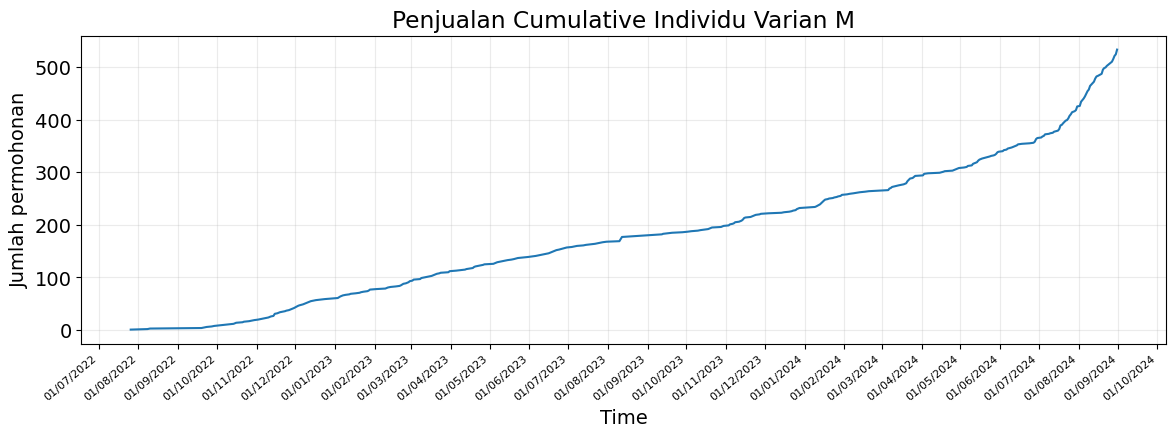

In [11]:
plot_time_series(df_M_count["Tgl. Mohon"], df_M_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah permohonan", title="Penjualan Cumulative Individu Varian M")

## Feature engineering

In [12]:
df_M_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,288,288.000000,288.000000
mean,2023-10-04 12:00:00,1.850694,213.892361
min,2022-07-26 00:00:00,1.000000,1.000000
25%,2023-03-02 18:00:00,1.000000,95.500000
50%,2023-11-01 00:00:00,1.000000,198.500000
75%,2024-05-14 06:00:00,2.000000,319.750000
max,2024-08-31 00:00:00,9.000000,533.000000
std,NaN,1.451396,138.770957


- Karena `count` mayoritas tanggal hanya memiliki 1 permohonan, dan hanya sebagian kecil yang mengalami lonjakan signifikan seperti 7.
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window) atau perubahan kumulatif
- Encoding waktu ke bentuk sin dan cos agar model dapat mengenali pola musiman

yang dilakukan
1. Mengurutkan data berdasarkan tanggal permohonan untuk rolling window
2. Menambah fitur baru:
    - `rolling_7days` untuk jumlah permohonan dalam 7 hari terakhir
    - `rolling_std_7d` untuk melihat fluktuasi (standar deviasi) permintaan dalam 7 hari terakhir
    - `delta_count` untuk melihat selisih jumlah permohonan di hari sebelumnya
    - `month` untuk melihat pola data lebih banyak di bulan apa
    - `weekday` untuk melihat pola data lebih banyak di awal atau alhir minggu

### Add Fitur

In [13]:
df_M_rolling = df_M_count.copy()
df_M_rolling = df_M_rolling.sort_values("Tgl. Mohon").reset_index(drop=True)

df_M_rolling["rolling_7days"] = df_M_rolling["count"].rolling(window=7, min_periods=1).sum()
df_M_rolling["rolling_count_7d"] = df_M_rolling["count"].rolling(window=7, min_periods=1).count()
df_M_rolling['delta_count'] = df_M_rolling['count'].diff().fillna(0)

# Ekstraksi informasi waktu
df_M_rolling['month'] = df_M_rolling['Tgl. Mohon'].dt.month
df_M_rolling['weekday'] = df_M_rolling['Tgl. Mohon'].dt.weekday
df_M_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday
0,2022-07-26,1,1,1.0,1.0,0.0,7,1
1,2022-08-08,1,2,2.0,2.0,0.0,8,0
2,2022-08-10,1,3,3.0,3.0,0.0,8,2
3,2022-09-19,1,4,4.0,4.0,0.0,9,0
4,2022-09-23,2,6,6.0,5.0,1.0,9,4
...,...,...,...,...,...,...,...,...
283,2024-08-27,2,510,23.0,7.0,-2.0,8,1
284,2024-08-28,5,515,20.0,7.0,3.0,8,2
285,2024-08-29,6,521,23.0,7.0,1.0,8,3
286,2024-08-30,3,524,25.0,7.0,-3.0,8,4


### Encoding untuk waktu ke data kategori harian (sin cos)

3. Menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

In [14]:
df_M_rolling['month_sin'] = np.sin(2 * np.pi * df_M_rolling['month'] / 12)
df_M_rolling['month_cos'] = np.cos(2 * np.pi * df_M_rolling['month'] / 12)

df_M_rolling['weekday_sin'] = np.sin(2 * np.pi * df_M_rolling['weekday'] / 7)
df_M_rolling['weekday_cos'] = np.cos(2 * np.pi * df_M_rolling['weekday'] / 7)
df_M_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2022-07-26,1,1,1.0,1.0,0.0,7,1,-0.500000,-8.660254e-01,0.781831,0.623490
1,2022-08-08,1,2,2.0,2.0,0.0,8,0,-0.866025,-5.000000e-01,0.000000,1.000000
2,2022-08-10,1,3,3.0,3.0,0.0,8,2,-0.866025,-5.000000e-01,0.974928,-0.222521
3,2022-09-19,1,4,4.0,4.0,0.0,9,0,-1.000000,-1.836970e-16,0.000000,1.000000
4,2022-09-23,2,6,6.0,5.0,1.0,9,4,-1.000000,-1.836970e-16,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-08-27,2,510,23.0,7.0,-2.0,8,1,-0.866025,-5.000000e-01,0.781831,0.623490
284,2024-08-28,5,515,20.0,7.0,3.0,8,2,-0.866025,-5.000000e-01,0.974928,-0.222521
285,2024-08-29,6,521,23.0,7.0,1.0,8,3,-0.866025,-5.000000e-01,0.433884,-0.900969
286,2024-08-30,3,524,25.0,7.0,-3.0,8,4,-0.866025,-5.000000e-01,-0.433884,-0.900969


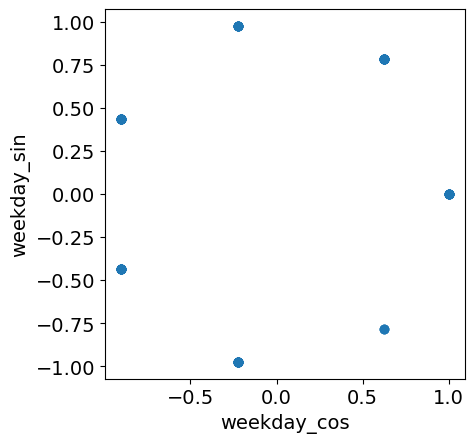

In [15]:
n_sample = 100   # randomly sample from the df_J_rolling

fig, ax = plt.subplots()

sampled_data = df_M_rolling.sample(n_sample)
ax.plot(sampled_data["weekday_cos"], sampled_data["weekday_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("weekday_cos")
ax.set_ylabel("weekday_sin")
plt.show(fig)

In [16]:
df_M_rolling.describe()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,2.880000e+02,288.000000,288.000000
mean,2023-10-04 12:00:00,1.850694,213.892361,12.552083,6.927083,0.027778,6.458333,2.718750,8.391311e-04,-4.039575e-02,0.079554,-0.112628
min,2022-07-26 00:00:00,1.000000,1.000000,1.000000,1.000000,-6.000000,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969
25%,2023-03-02 18:00:00,1.000000,95.500000,9.000000,7.000000,-1.000000,3.750000,1.000000,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969
50%,2023-11-01 00:00:00,1.000000,198.500000,11.000000,7.000000,0.000000,7.000000,3.000000,-2.449294e-16,-1.836970e-16,0.000000,-0.222521
75%,2024-05-14 06:00:00,2.000000,319.750000,13.000000,7.000000,1.000000,9.000000,4.000000,5.000000e-01,8.660254e-01,0.781831,0.623490
max,2024-08-31 00:00:00,9.000000,533.000000,38.000000,7.000000,7.000000,12.000000,6.000000,1.000000e+00,1.000000e+00,0.974928,1.000000
std,NaN,1.451396,138.770957,6.564931,0.558335,1.568170,3.422359,1.780869,6.678266e-01,7.455560e-01,0.694484,0.708587


In [17]:
# Menghitung korelasi antar kolom numerik
corr_matrix = df_M_rolling.corr()
print(corr_matrix)


                  Tgl. Mohon     count  cumulative_sum  rolling_7days  \
Tgl. Mohon          1.000000  0.412603        0.975077       0.607355   
count               0.412603  1.000000        0.498838       0.686653   
cumulative_sum      0.975077  0.498838        1.000000       0.724412   
rolling_7days       0.607355  0.686653        0.724412       1.000000   
rolling_count_7d    0.237361  0.068213        0.199341       0.194485   
delta_count         0.021502  0.578968        0.030227       0.035396   
month              -0.102130  0.037675       -0.067495       0.039255   
weekday            -0.100256  0.018746       -0.086282      -0.011707   
month_sin          -0.086497 -0.216956       -0.169632      -0.295761   
month_cos          -0.501055 -0.227278       -0.527620      -0.315215   
weekday_sin         0.076028  0.023783        0.069180       0.039112   
weekday_cos         0.015657 -0.005369        0.005081      -0.022252   

                  rolling_count_7d  delta_count   

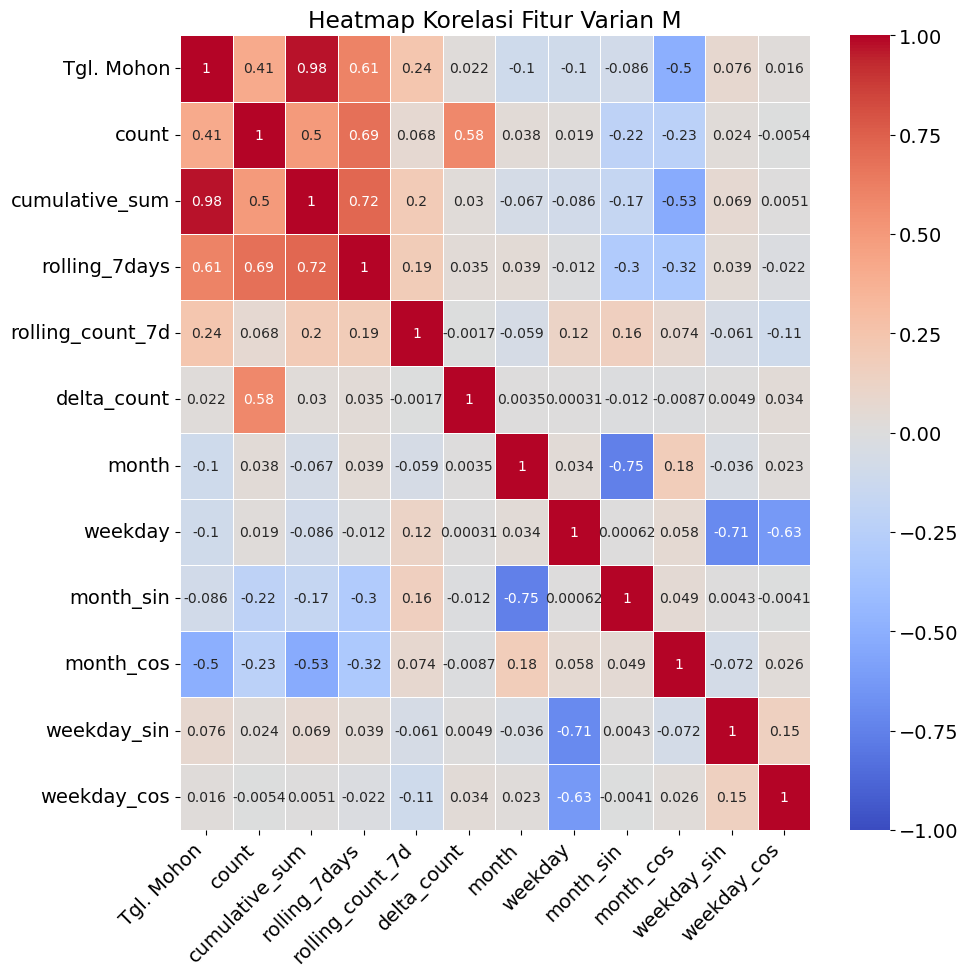

In [18]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5,
    vmin=-1, vmax=1, annot_kws={"size": 10})
plt.title("Heatmap Korelasi Fitur Varian M")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### Data Splitting

In [19]:
n_data = len(df_M_rolling)

# Split 70:20:10 (train:validation:set)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)

train_df = df_M_rolling[:idx_train].copy()
val_df = df_M_rolling[idx_train:idx_test].copy()
test_df = df_M_rolling[idx_test:].copy()


print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (201, 58, 29)


In [20]:
train_df

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2022-07-26,1,1,1.0,1.0,0.0,7,1,-0.500000,-8.660254e-01,0.781831,0.623490
1,2022-08-08,1,2,2.0,2.0,0.0,8,0,-0.866025,-5.000000e-01,0.000000,1.000000
2,2022-08-10,1,3,3.0,3.0,0.0,8,2,-0.866025,-5.000000e-01,0.974928,-0.222521
3,2022-09-19,1,4,4.0,4.0,0.0,9,0,-1.000000,-1.836970e-16,0.000000,1.000000
4,2022-09-23,2,6,6.0,5.0,1.0,9,4,-1.000000,-1.836970e-16,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...
196,2024-03-23,5,288,19.0,7.0,1.0,3,5,1.000000,6.123234e-17,-0.974928,-0.222521
197,2024-03-25,1,289,19.0,7.0,-4.0,3,0,1.000000,6.123234e-17,0.000000,1.000000
198,2024-03-26,2,291,19.0,7.0,1.0,3,1,1.000000,6.123234e-17,0.781831,0.623490
199,2024-03-27,2,293,18.0,7.0,0.0,3,2,1.000000,6.123234e-17,0.974928,-0.222521


C:\Users\TEMP\AppData\Local\Temp\ipykernel_5504\880389611.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


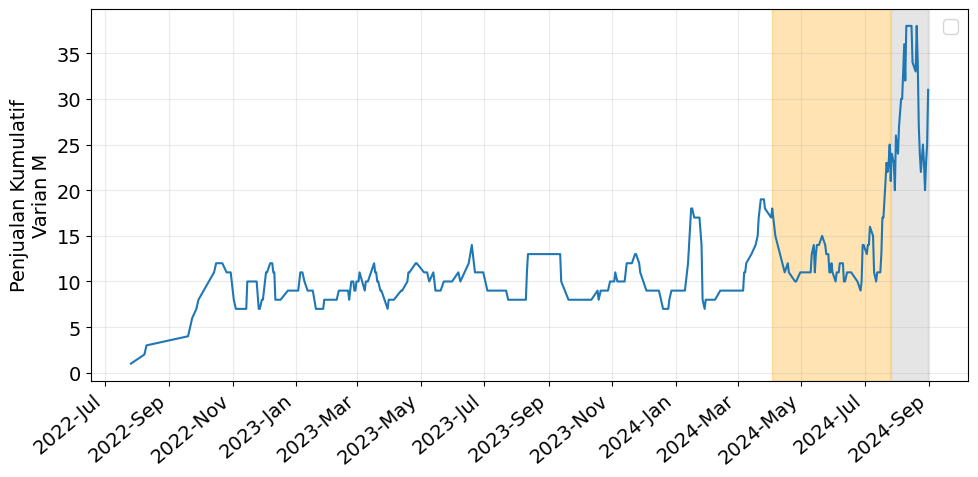

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_M_rolling['Tgl. Mohon'], df_M_rolling["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian M")
# ax.set_title("Data Splitting (Train/Val/Test)")
ax.legend()
# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_fontsize(8)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


scaling data

In [22]:
column_for_scaling = ["count", "cumulative_sum", "rolling_7days",
                    "rolling_count_7d", "delta_count", "month", "weekday",
                    "month_sin", "month_cos", "weekday_sin", "weekday_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

# Scaling train, val, test
train_scale_df_m = train_df.copy()
val_scale_df_m = val_df.copy()
test_scale_df_m = test_df.copy()

train_scale_df_m[column_for_scaling] = scaler_obj.transform(train_scale_df_m[column_for_scaling])
val_scale_df_m[column_for_scaling] = scaler_obj.transform(val_scale_df_m[column_for_scaling])
test_scale_df_m[column_for_scaling] = scaler_obj.transform(test_scale_df_m[column_for_scaling])

display(train_scale_df_m.head())
display(val_scale_df_m.head())
display(test_scale_df_m.head())

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2022-07-26,0.000000,0.000000,0.000000,0.000000,0.625,0.545455,0.166667,0.250000,0.066987,0.900969,0.801938
1,2022-08-08,0.000000,0.003413,0.055556,0.166667,0.625,0.636364,0.000000,0.066987,0.250000,0.500000,1.000000
2,2022-08-10,0.000000,0.006826,0.111111,0.333333,0.625,0.636364,0.333333,0.066987,0.250000,1.000000,0.356896
3,2022-09-19,0.000000,0.010239,0.166667,0.500000,0.625,0.727273,0.000000,0.000000,0.500000,0.500000,1.000000
4,2022-09-23,0.166667,0.017065,0.277778,0.666667,0.750,0.727273,0.666667,0.000000,0.500000,0.277479,0.000000


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
201,2024-04-03,0.333333,1.010239,0.944444,1.0,0.875,0.272727,0.333333,0.933013,0.25,1.000000,3.568959e-01
202,2024-04-06,0.000000,1.013652,0.777778,1.0,0.375,0.272727,0.833333,0.933013,0.25,0.000000,3.568959e-01
203,2024-04-15,0.000000,1.017065,0.555556,1.0,0.625,0.272727,0.000000,0.933013,0.25,0.500000,1.000000e+00
204,2024-04-18,0.166667,1.023891,0.611111,1.0,0.750,0.272727,0.500000,0.933013,0.25,0.722521,5.551115e-17
205,2024-04-19,0.000000,1.027304,0.555556,1.0,0.500,0.272727,0.666667,0.933013,0.25,0.277479,0.000000e+00


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
259,2024-07-26,0.333333,1.395904,1.111111,1.0,0.375,0.545455,0.666667,0.25,0.066987,0.277479,0.000000
260,2024-07-27,0.500000,1.409556,1.277778,1.0,0.750,0.545455,0.833333,0.25,0.066987,0.000000,0.356896
261,2024-07-29,0.166667,1.416382,1.222222,1.0,0.375,0.545455,0.000000,0.25,0.066987,0.500000,1.000000
262,2024-07-30,0.166667,1.423208,1.055556,1.0,0.625,0.545455,0.166667,0.25,0.066987,0.900969,0.801938
263,2024-07-31,1.000000,1.447099,1.388889,1.0,1.250,0.545455,0.333333,0.25,0.066987,1.000000,0.356896


In [23]:
train_scale_df_m.to_csv("./data/train_scale_m.csv", index=False)
val_scale_df_m.to_csv("./data/val_scale_m.csv", index=False)
test_scale_df_m.to_csv("./data/test_scale_m.csv", index=False)

In [24]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df_m"] = pd.read_csv(f"./data/{section}_scale_m.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df_m"]

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2022-07-26,0.000000,0.000000,0.000000,0.000000,0.625,0.545455,0.166667,0.250000,0.066987,0.900969,0.801938
1,2022-08-08,0.000000,0.003413,0.055556,0.166667,0.625,0.636364,0.000000,0.066987,0.250000,0.500000,1.000000
2,2022-08-10,0.000000,0.006826,0.111111,0.333333,0.625,0.636364,0.333333,0.066987,0.250000,1.000000,0.356896
3,2022-09-19,0.000000,0.010239,0.166667,0.500000,0.625,0.727273,0.000000,0.000000,0.500000,0.500000,1.000000
4,2022-09-23,0.166667,0.017065,0.277778,0.666667,0.750,0.727273,0.666667,0.000000,0.500000,0.277479,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
196,2024-03-23,0.666667,0.979522,1.000000,1.000000,0.750,0.181818,0.833333,1.000000,0.500000,0.000000,0.356896
197,2024-03-25,0.000000,0.982935,1.000000,1.000000,0.125,0.181818,0.000000,1.000000,0.500000,0.500000,1.000000
198,2024-03-26,0.166667,0.989761,1.000000,1.000000,0.750,0.181818,0.166667,1.000000,0.500000,0.900969,0.801938
199,2024-03-27,0.166667,0.996587,0.944444,1.000000,0.625,0.181818,0.333333,1.000000,0.500000,1.000000,0.356896


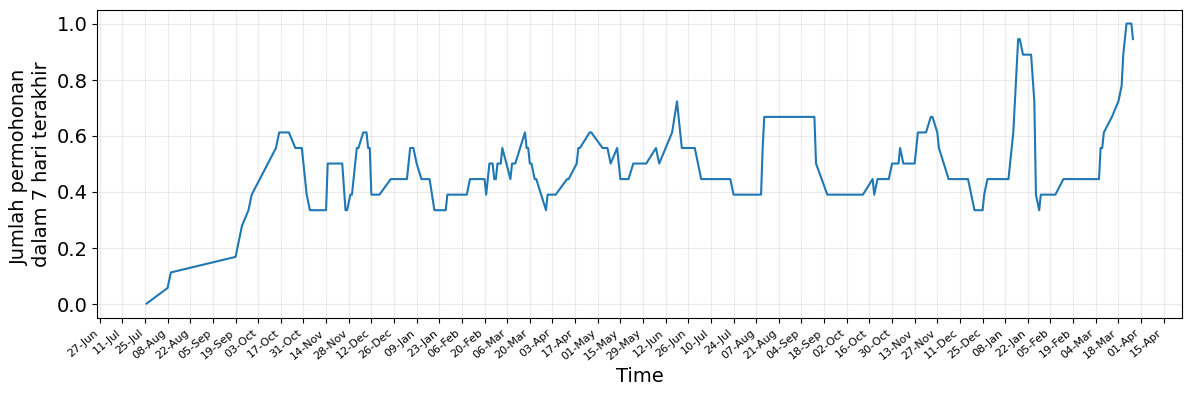

In [25]:
num_of_rows = 200
train_scale_df_m_selected = dataset["train_scale_df_m"]
plot_time_series(train_scale_df_m_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_m_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

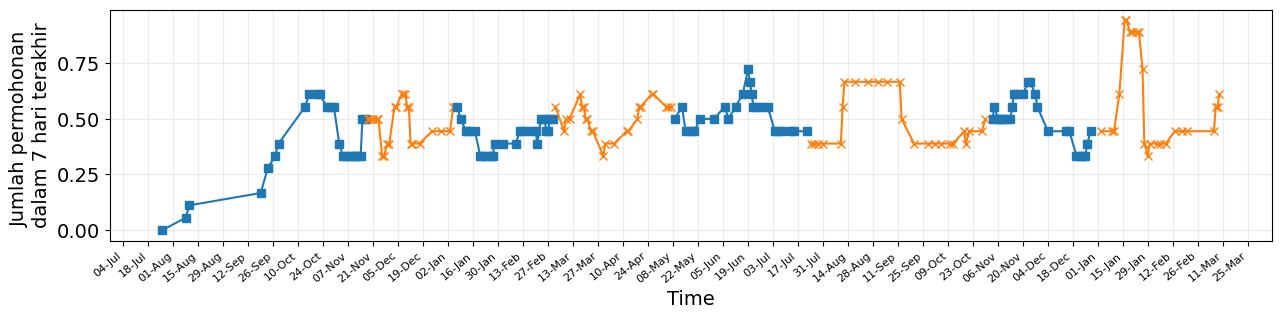

In [26]:
num_of_rows = 200
train_scale_df_m_selected = dataset["train_scale_df_m"]
plot_time_series_data_window(train_scale_df_m_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_m_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir", figsize=(15, 3),
                  use_weekday_locator=True, use_year_locator=False)

## Model Development

In [27]:
# --- Fungsi Membuat Sequence (samples, timesteps, features) ---
def create_multivariate_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(sequence_length, len(X)):
        Xs.append(X[i-sequence_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [28]:
# --- Setup Kolom ---
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]
input_columns_autoreg = input_columns + ["rolling_7days"]

feature_col = "rolling_7days"

train_X = train_scale_df_m[input_columns].values
val_X = val_scale_df_m[input_columns].values
test_X = test_scale_df_m[input_columns].values

train_y = train_scale_df_m[feature_col].values
val_y = val_scale_df_m[feature_col].values
test_y = test_scale_df_m[feature_col].values

sequence_length = 10
X_train, y_train = create_multivariate_sequences(train_X, train_y, sequence_length)
X_val, y_val = create_multivariate_sequences(val_X, val_y, sequence_length)

In [29]:
# --- Model LSTM ---
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,689 (479.25 KB)

 Trainable params: 122,689 (479.25 KB)

 Non-trainable params: 0 (0.00 B)

### Data Training

epoch = 50

In [30]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - loss: 0.2335 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0872 - val_loss: 0.1069 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0552 - val_loss: 0.1102 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0544 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0455 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0345 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0363 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0342 - val_loss: 0.0484 - learning_rate: 0.0010
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0388 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 10/100
6/6 ━━━━━━━━━━

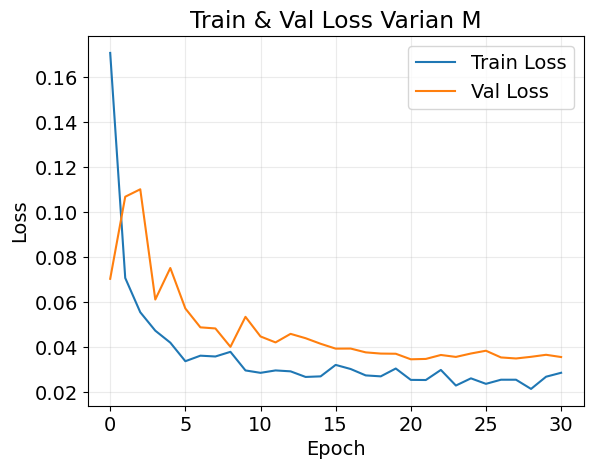

In [31]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train & Val Loss Varian M')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.show()

### Prediksi `rolling 7 days`

In [32]:
# --- Fungsi Prediksi Autoregressive ---
# Ambil kolom yang digunakan sebagai input ke model
input_columns = [col for col in column_for_scaling if col != "rolling_7days"]

# Ambil sequence terakhir dari validation sebagai seed
last_sequence = val_scale_df_m[input_columns + ["rolling_7days"]].values[-sequence_length:].copy()

# Placeholder untuk menyimpan hasil prediksi (dalam skala yang sudah di-scale)
scaled_preds = []

# Autoregressive loop
for i in range(len(test_df)):
    # Pisahkan input features dan target dari last_sequence
    X_input = last_sequence[:, :-1]  # semua kolom kecuali rolling_7days (fitur input)
    X_input = X_input.reshape(1, sequence_length, len(input_columns))

    # Prediksi rolling_7days berikutnya
    pred_scaled = model.predict(X_input, verbose=0)[0][0]
    scaled_preds.append(pred_scaled)

    # Buat baris baru untuk update sequence
    next_row = last_sequence[-1].copy()
    next_row[:-1] = test_scale_df_m[input_columns].values[i]  # update input fitur
    next_row[-1] = pred_scaled  # rolling_7days hasil prediksi

    # Tambahkan ke sequence (geser window)
    last_sequence = np.vstack([last_sequence[1:], next_row])


In [33]:
# --- Inverse Scaling ---
# Konversi prediksi ke DataFrame agar bisa di-inverse scaling
preds_df_scaled = test_scale_df_m.iloc[:len(scaled_preds)].copy()
preds_df_scaled["rolling_7days"] = scaled_preds

# Inverse transform
preds_inverse = scaler_obj.inverse_transform(preds_df_scaled[column_for_scaling])[:, column_for_scaling.index("rolling_7days")]

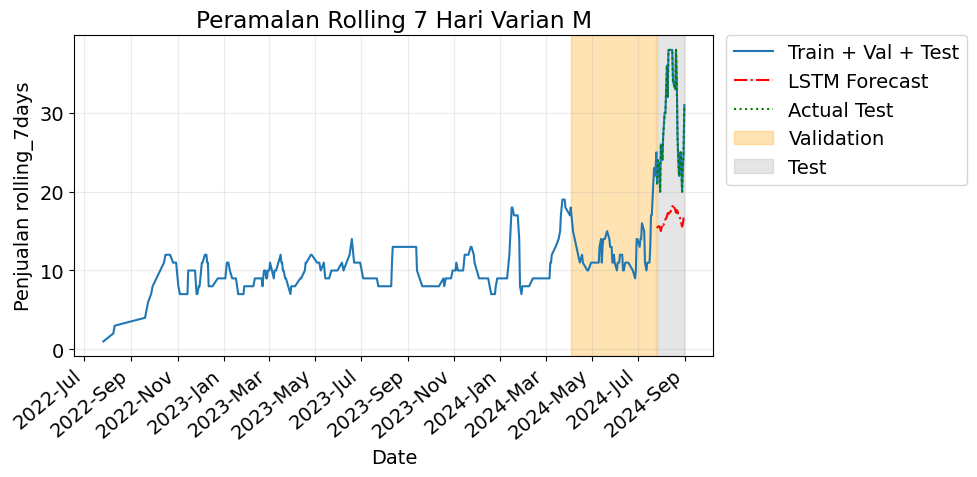

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

all_dates = pd.concat([train_df, val_df, test_df], ignore_index=True)['Tgl. Mohon']
rolling_values = pd.concat([train_df, val_df, test_df], ignore_index=True)['rolling_7days']

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling_7days")
ax.set_title("Peramalan Rolling 7 Hari Varian M")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_fontsize(5)
    label.set_horizontalalignment('right')

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


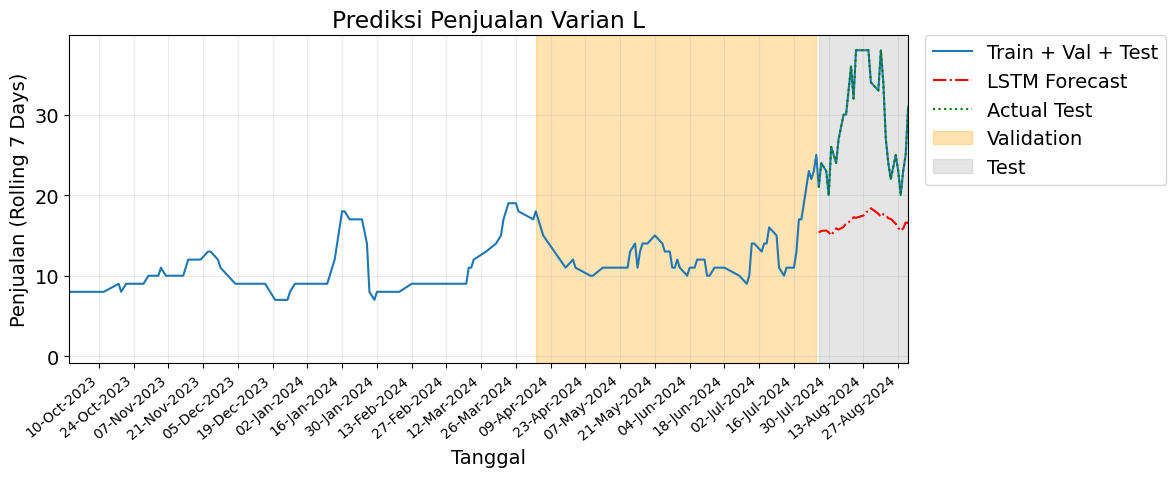

In [35]:
start_idx = 134

xlim = [all_dates.iloc[start_idx], test_df["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(all_dates, rolling_values, label="Train + Val + Test")
ax.plot(test_df["Tgl. Mohon"], preds_inverse, "r-.", label="LSTM Forecast")
ax.plot(test_df["Tgl. Mohon"], test_df["rolling_7days"], "g:", label="Actual Test")

formatter = mdates.DateFormatter("%d-%b-%Y")
locator = mdates.DayLocator(interval=14)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian M")
ax.grid("on")

# Area validation dan test
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
                    color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

ax.set_xlim(xlim)
ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Prediksi Penjualan Varian L")
ax.grid("on")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_size(10)
    label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.tight_layout()
plt.show()


In [36]:
# --- Ground truth dan prediksi ---
y_true = test_df["rolling_7days"].values
y_pred = preds_inverse[:len(y_true)]  # pastikan sama panjangnya

# --- Evaluasi ---
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# --- MASE (Mean Absolute Scaled Error) ---
# Menggunakan MAE dari naive forecast (persistence model) sebagai pembagi
# Persistence: y_t ≈ y_{t-1}
naive_forecast = y_true[:-1]
actual = y_true[1:]

mae_naive = np.mean(np.abs(actual - naive_forecast))
mase = mae / mae_naive

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.2f}")

MAE  : 12.23
MAPE : 40.30%
MSE  : 178.78
RMSE : 13.37
MASE : 4.18
